In [1]:
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from collections import namedtuple
import os
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from src.utils import normalize, setup_dataset

%matplotlib inline

def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)
torch.cuda.set_device(0)

In [11]:
256/8

32

In [33]:
ngpu = 1
nz = 100
ngf = 32
ndf = 64
nc = 3


class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
            # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)
netG.load_state_dict(torch.load('/home/dulyanov/projects/pytorch/examples/dcgan/data/dcgan_cifar10_32/netG_epoch_24.pth'))

class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1)


netD = _netD(ngpu)

netD.load_state_dict(torch.load('/home/dulyanov/projects/pytorch/examples/dcgan/data/dcgan_cifar10_32/netD_epoch_24.pth'))
print(netD)

_netD (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid ()
  )
)


In [39]:
dtype = torch.cuda.FloatTensor

netD = netD.type(dtype)
netG = netG.type(dtype)

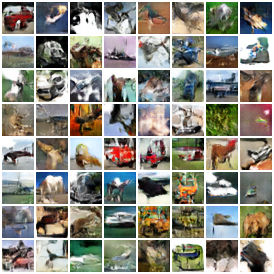

In [49]:

z = Variable(dtype(64, nz, 1, 1).normal_(0, 1), volatile=True)
# z = normalize(z)

samples = netG(z).data.cpu()

grid = torchvision.utils.make_grid(samples/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

In [45]:
!mv cifar10_dcgan samples_cifar10_dcgan

In [46]:
for j in range(40):
    print(j)
    z = Variable(dtype(256, nz, 1, 1).normal_(0, 1), volatile=True)
    z = normalize(z)
    
    samples = netG(z).data.cpu()/2 + 0.5

    for i in range(samples.size(0)):
        torchvision.utils.save_image(samples[i], 'samples_cifar10_dcgan/%d_%d.png' % (j, i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [30]:
s = torch.load('/home/dulyanov/projects/pytorch/examples/dcgan/data/dcgan_cifar10_32/netD_epoch_24.pth')

In [31]:
[s[k].size() for k in s.keys()]

[torch.Size([64, 3, 4, 4]),
 torch.Size([128, 64, 4, 4]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([256, 128, 4, 4]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([1, 256, 4, 4])]

In [32]:
dd = netD.state_dict()
[dd[k].size() for k in dd.keys()]

[torch.Size([64, 3, 4, 4]),
 torch.Size([128, 64, 4, 4]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([256, 128, 4, 4]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([256]),
 torch.Size([512, 256, 4, 4]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([1, 512, 4, 4])]

In [19]:
['main.3.weight'].size()

torch.Size([256, 128, 4, 4])

In [3]:
torch.load('/home/dulyanov/projects/pytorch/examples/dcgan/data/dcgan_cifar10_32/netD_epoch_24.pth')

OrderedDict([('main.0.weight', 
              (0 ,0 ,.,.) = 
               -1.9267e-02  1.6724e-02  9.8544e-02  2.4191e-02
               -2.5958e-02 -6.0640e-02 -3.6686e-02 -4.3603e-02
               -1.3668e-02  6.3345e-02  4.7718e-02  1.8516e-02
               -3.7538e-02 -3.4790e-02  2.0396e-02 -6.7473e-03
              
              (0 ,1 ,.,.) = 
               -1.1049e-02  5.0568e-04 -3.0845e-03  1.5941e-02
                1.8116e-02  1.4131e-03 -1.0042e-02 -4.8560e-02
               -1.7359e-02  4.4107e-02 -7.0496e-04  1.8483e-02
               -5.5825e-03 -9.4838e-03 -7.5597e-03  1.2932e-02
              
              (0 ,2 ,.,.) = 
               -1.0298e-02 -2.9474e-02 -9.5446e-05  2.0077e-02
                3.7273e-02 -2.2532e-02 -2.8397e-02 -2.3372e-02
                4.3309e-02  5.1598e-02 -2.3196e-02 -8.1224e-03
                2.6598e-02 -1.4542e-02 -2.8162e-02  2.6492e-02
                   ⋮ 
              
              (1 ,0 ,.,.) = 
                1.5071e-02 -8

In [2]:
############################

DATASET = 'cifar10'  # cifar10, imagenet

############################

In [32]:
dtype = torch.cuda.FloatTensor

opt=({      
         'nz':256, 
         'nout':128,
         'ngf':64, 
         'ndf': 64, 
         'noise': 'sphere',
         'ngpu': 1,
         'dataset': 'cifar10',
         'image_size':32,
         'workers':0,
         'batch_size': 64,
        })

if DATASET=='cifar10':
    # default params work for cifar10
    pass
elif DATASET== 'imagenet':
    opt['dataset'] = 'imagenet'
    opt['dataroot'] = '/sdh/data/imagenet' # put here your path
elif DATASET=='celeba':
    opt.update({      
             'nz':64, 
             'dataset': 'celeba',
             'dataroot': '/sdh/data/celebA/imgs1', # put here your path
             'image_size':64, 
            })

opt['nc'] =  1 if opt['dataset'] == 'mnist' else 3
opt['netG'] = 'dcgan32px'
opt['netE'] = 'dcgan32px'
opt['netG_chp'] = ''
opt['netE_chp'] = ''
opt1 = opt
opt= convert(opt)

In [33]:
import pickle
from src.utils import *
# Load g,e
E_path = 'pretrained/%s_e.pth' % DATASET
G_path = 'pretrained/%s_g.pth' % DATASET

# E_path = 'pretrained/%s_e.pth' % DATASET
# G_path = 'pretrained/%s_g.pth' % DATASET
Dstr = '../data/checkpoints/KL_qp_cifar10_sphereDp_avgpool_match_z_/netD_epoch_24.pth'
Gstr = '../data/checkpoints/KL_qp_cifar10_sphereDp_avgpool_match_z_/netG_epoch_24.pth'

E_path = '/home/dulyanov/projects/icml2017/figs_code/' + Dstr
G_path = '/home/dulyanov/projects/icml2017/figs_code/' + Gstr

# netG = torch.load(G_path).type(dtype)
# netE = torch.load(E_path).type(dtype)
    
netG, netD = None,None
if True:
    opt1['netG'] = 'dcgan32px'
    opt1['netE'] = 'dcgan32px'
    netG = load_G(opt)
    netE = load_E(opt)
#     netG.main.load_state_dict(torch.load(G_path).main.state_dict())
#     netE.main.load_state_dict(torch.load(E_path).main.state_dict())
    netG.load_state_dict(torch.load(G_path))
    netE.load_state_dict(torch.load(E_path))
else:
    netG = torch.load(Gstr).type(torch.FloatTensor)
    netD = torch.load(Dstr).type(torch.FloatTensor)
    
netG = netG.type(dtype)
netE = netE.type(dtype)
# netG.eval()
# netE.eval()

# netG.eval()
netE.eval()

('Generator\n', _netG_Base (
  (main): Sequential (
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
    (13): Tanh ()
  )
))
('Encoder\n', _netE_Base (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

RuntimeError: sizes do not match at /py/conda-bld/pytorch_1493676237139/work/torch/lib/THC/generic/THCTensorCopy.c:95

In [5]:
__imp

/home/dulyanov/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
attr = pd.read_csv('/home/dulyanov/list_attr_celeba.txt', delimiter=',')

In [9]:
dataloader = setup_dataset(opt, train=True, shuffle = False, drop_last=False)

In [13]:
# names = dataloader.dataloader.dataset.image_filenames
# np.save('names.npy', names)

names = np.load('names.npy')

In [71]:
# from tqdm import tqdm_notebook
# codes = []

# dataloader = setup_dataset(opt, train=True, shuffle = False, drop_last=False)
# for (input, _) in tqdm_notebook(dataloader.dataloader):
#     x = Variable(input, volatile=True)
#     ex = netE(x)
    
#     codes.append(ex.data)
# codes_ = torch.cat(codes)

codes_ = torch.load('codes.pth')
c = codes_.numpy()


a = attr.loc[[x.split('/')[-1] for x in names]]

avg_smiling = c[(a.Smiling == 1).values].mean(0)
avg_not_smiling = c[(a.Smiling == -1).values].mean(0)

# Sample

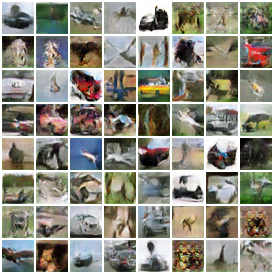

In [23]:
z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(None, z).data.cpu()

grid = torchvision.utils.make_grid(samples/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

In [8]:
!mkdir samples_cifar10_1

In [6]:
5000/256

19

In [14]:
for j in range(40):
    print(j)
    z = Variable(dtype(256, opt.nz, 1, 1).normal_(0, 1), volatile=True)
    z = normalize(z)
    
    samples = netG(None, z).data.cpu()/2 + 0.5

    for i in range(samples.size(0)):
        torchvision.utils.save_image(samples[i], 'samples_cifar10_1/%d_%d.png' % (j, i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


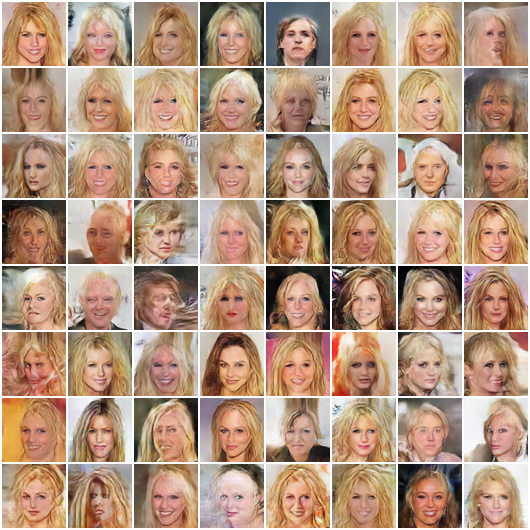

In [58]:
# z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
t = Variable(torch.from_numpy(avg_smiling- avg_not_smiling).view(1,opt.nz,1,1).expand_as(z.data))
t = normalize(t)
z1 = z + 0.4*t
z1 = normalize(z1)

samples1 = netG(None, z1).data.cpu()

grid = torchvision.utils.make_grid(samples1/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

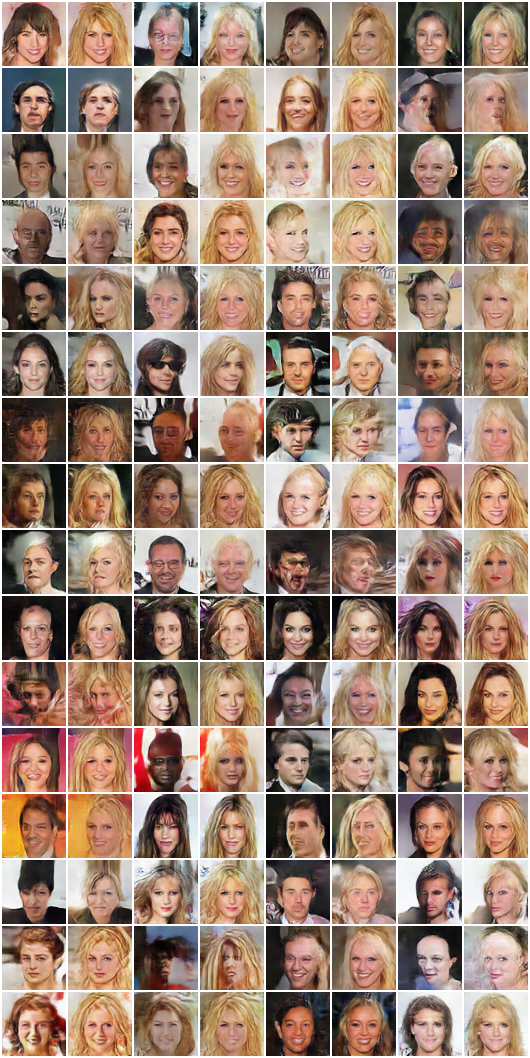

In [60]:
x = samples


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = samples.cpu()[:]
t[1::2] = samples1.cpu()[:]


# torch.cat([samples[::2],samples1[::2]])
# samples
grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

# Reconstruct

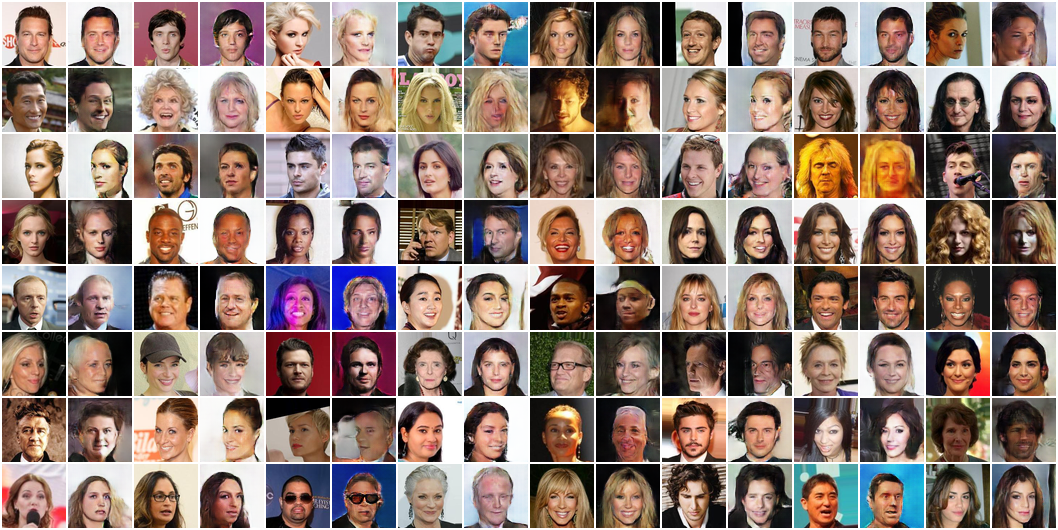

In [75]:
x = Variable(d[0], volatile=True)

ex = netE(x)
gex = netG(None, ex)


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = x.data.cpu()[:]
t[1::2] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1, nrow=16)
grid_PIL = transforms.ToPILImage()(grid)


grid_PIL

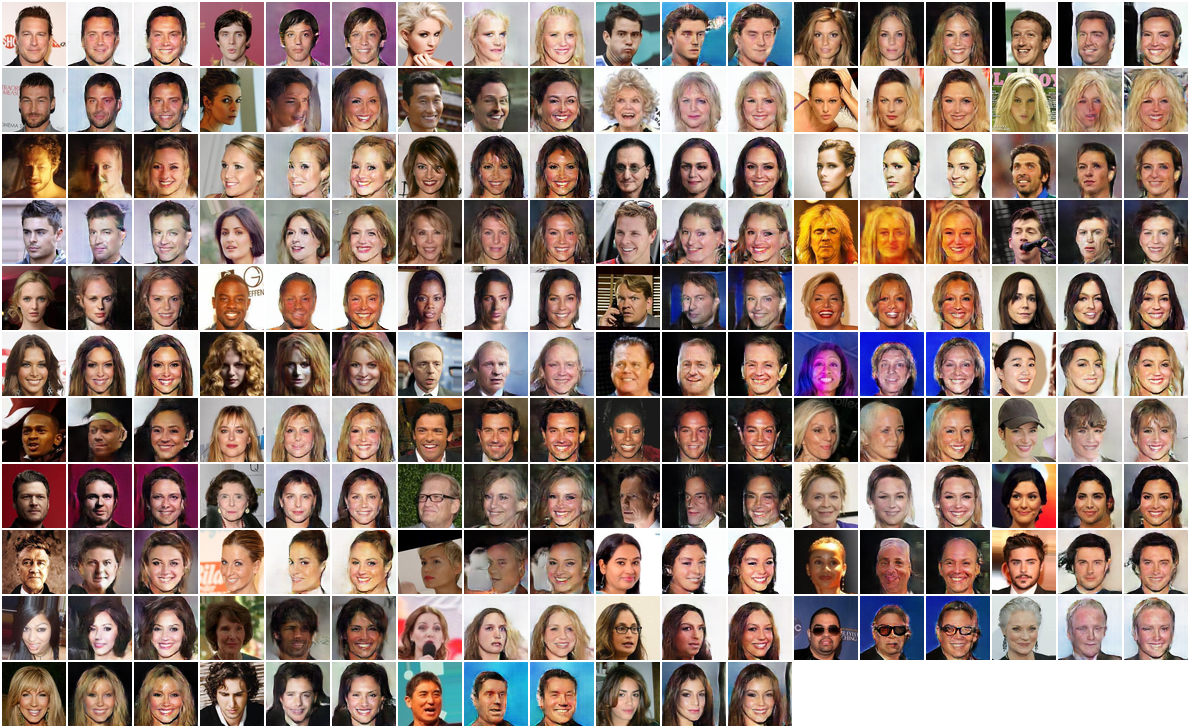

In [81]:
# x = Variable(d[0], volatile=True)

t = Variable(torch.from_numpy(avg_smiling- avg_not_smiling).view(1,opt.nz,1,1).expand_as(z.data))
t = normalize(t)
ex1 = ex + 0.5*t

# ex = netE(x)
gex1 = netG(None, ex1)


t = torch.FloatTensor(x.size(0) * 3, x.size(1), x.size(2), x.size(3))
t[0::3] = x.data.cpu()[:]
t[1::3] = gex.data.cpu()[:]
t[2::3] = gex1.data.cpu()[:]


grid = torchvision.utils.make_grid(t/2 + 0.5, pad_value=1, nrow=18)
grid_PIL = transforms.ToPILImage()(grid)


grid_PIL